 # Segmentation of Brain Tissues

 ## The Dataset

 ### Load required libraries

In [19]:
import os
import random

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from Q1_dataprep import IBSRPatchDataset, get_slice_data

 ### Get data for all subjects

In [20]:
data_root = "IBSR_nifti_stripped"

subjects = sorted([
    d for d in os.listdir(data_root)
    if d.startswith("IBSR_") and os.path.isdir(os.path.join(data_root, d))
])

print("Found subjects:", subjects)

Found subjects: ['IBSR_01', 'IBSR_02', 'IBSR_03', 'IBSR_04', 'IBSR_05', 'IBSR_06', 'IBSR_07', 'IBSR_08', 'IBSR_09', 'IBSR_10', 'IBSR_11', 'IBSR_12', 'IBSR_13', 'IBSR_14', 'IBSR_15', 'IBSR_16', 'IBSR_17', 'IBSR_18']


 ### Read and store the files

In [21]:

volume_files = []
segmentation_files = []

for subj in subjects:
    subj_dir = os.path.join(data_root, subj)

    vol_name = f"{subj}_ana_strip.nii.gz"
    seg_name = f"{subj}_segTRI_fill_ana.nii.gz"

    vol_path = os.path.join(subj_dir, vol_name)
    seg_path = os.path.join(subj_dir, seg_name)

    volume_files.append(vol_path)
    segmentation_files.append(seg_path)

    # print(f"{subj}:")
    # print(f"  volume      -> {vol_path}")
    # print(f"  segmentation-> {seg_path}")

 ### Split data to training and testing sets

In [22]:
train_volume_files = volume_files[:12]
train_segmentation_files = segmentation_files[:12]

test_volume_files = volume_files[12:]
test_segmentation_files = segmentation_files[12:]

 ### Create dataset and data loaders

In [23]:
train_dataset = IBSRPatchDataset(train_volume_files, train_segmentation_files)
test_dataset = IBSRPatchDataset(test_volume_files, test_segmentation_files)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Loading and processing dataset (with rotation)...
Dataset loaded. Total patches: 6528
Loading and processing dataset (with rotation)...
Dataset loaded. Total patches: 3264


 ### Display data shape

In [24]:
for imgs, masks in train_loader:
    print("Train batch images:", imgs.shape)  # [B, 1, 128, 128]
    print("Train batch masks :", masks.shape)  # [B, 128, 128]
    break

Train batch images: torch.Size([1, 1, 128, 128])
Train batch masks : torch.Size([1, 128, 128])


 ### Visualize data for one of the patients

In [25]:
selected_indices = random.sample(range(len(volume_files)), 3)
print("Random patients:", selected_indices)

Random patients: [14, 12, 3]


In [26]:
class_colors = {
    0: (0, 0, 0),   # background
    1: (0, 0, 1),   # CSF
    2: (0, 1, 0),   # GM
    3: (1, 0, 0),   # WM
}

In [27]:
def colorize_mask(mask):
    mask_int = mask.astype(int)
    h, w = mask_int.shape
    rgb = np.zeros((h, w, 3), dtype=float)
    for lbl, col in class_colors.items():
        rgb[mask_int == lbl] = col
    return rgb


---------------------------------
Patient: 14
Volume: IBSR_nifti_stripped\IBSR_15\IBSR_15_ana_strip.nii.gz
---------------------------------


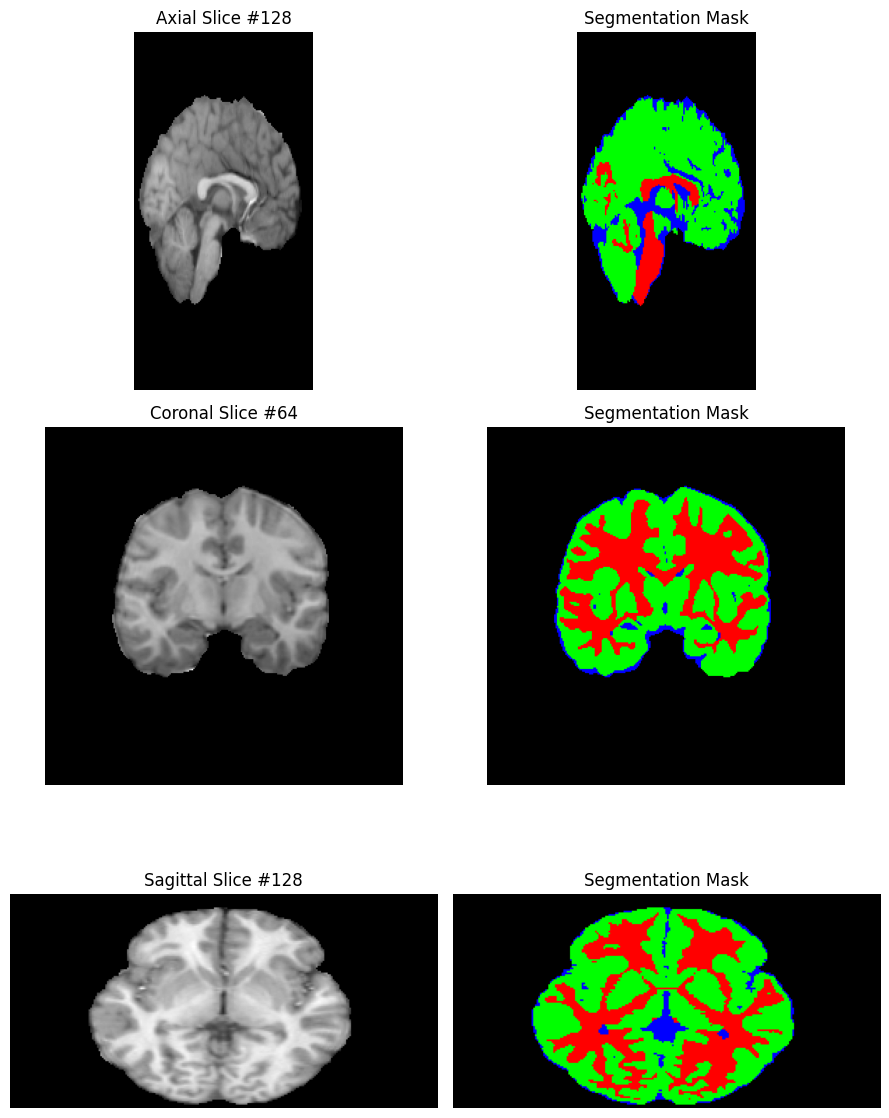


---------------------------------
Patient: 12
Volume: IBSR_nifti_stripped\IBSR_13\IBSR_13_ana_strip.nii.gz
---------------------------------


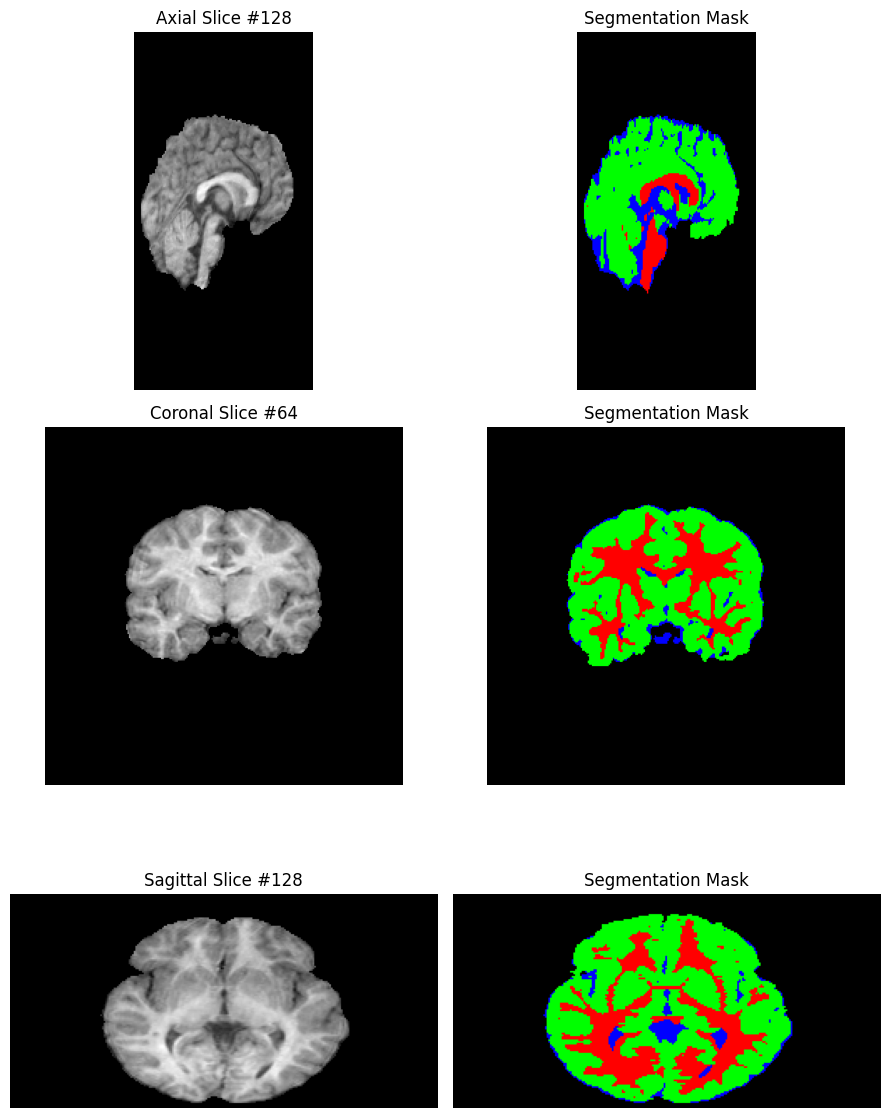


---------------------------------
Patient: 3
Volume: IBSR_nifti_stripped\IBSR_04\IBSR_04_ana_strip.nii.gz
---------------------------------


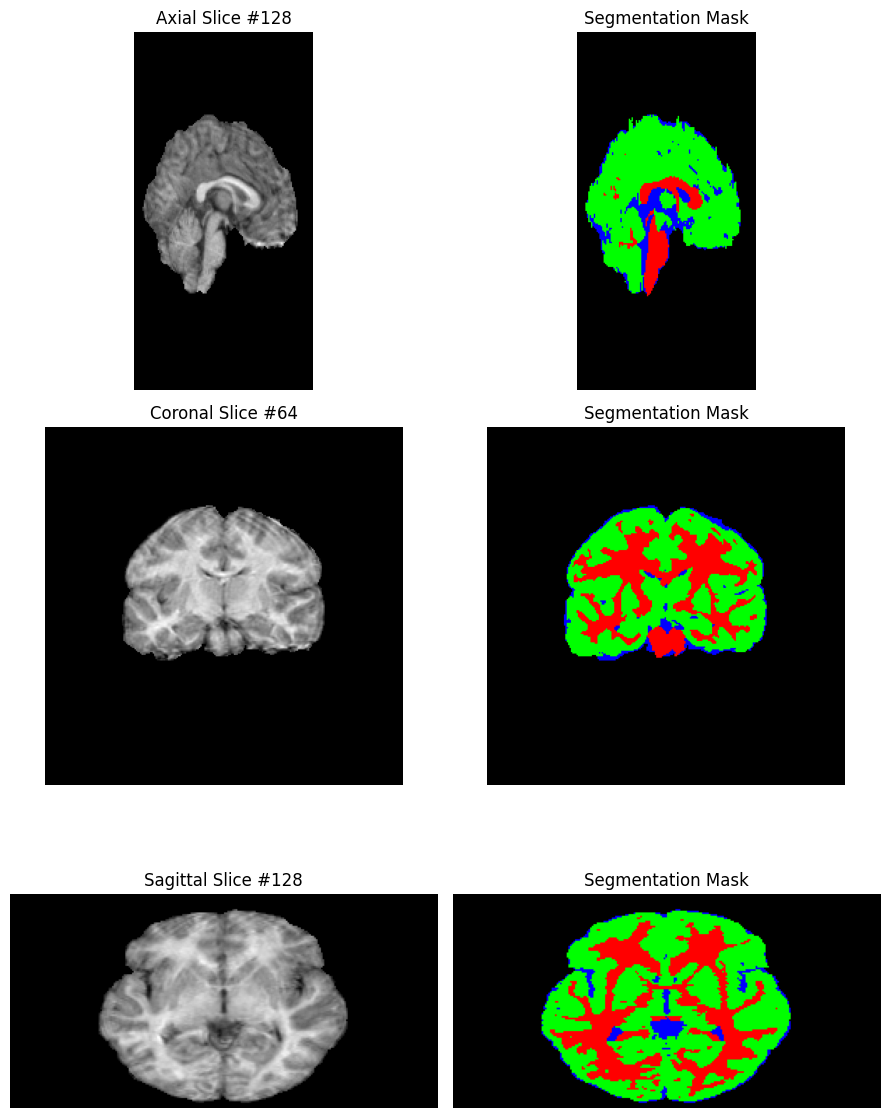

In [28]:


# ---------- Figure 1: full mid-slices (vol + mask) for 3 patients ----------
for idx in selected_indices:

    vol_path = volume_files[idx]
    seg_path = segmentation_files[idx]

    vol_data = nib.load(vol_path).get_fdata()
    seg_data = nib.load(seg_path).get_fdata()

    print("\n---------------------------------")
    print("Patient:", idx)
    print("Volume:", vol_path)
    print("---------------------------------")

    fig, axs = plt.subplots(3, 2, figsize=(9, 12))

    for axis, axis_name in enumerate(["Axial", "Coronal", "Sagittal"]):

        mid_slice = vol_data.shape[axis] // 2

        vol_slice, seg_slice = get_slice_data(
            vol_data,
            seg_data,
            axis,
            mid_slice
        )

        axs[axis, 0].imshow(vol_slice, cmap='gray')
        axs[axis, 0].set_title(f"{axis_name} Slice #{mid_slice}")
        axs[axis, 0].axis("off")

        rgb_mask = colorize_mask(seg_slice)
        axs[axis, 1].imshow(rgb_mask)
        axs[axis, 1].set_title("Segmentation Mask")
        axs[axis, 1].axis("off")

    plt.tight_layout()
    plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv1x1Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=1, padding=0, bias=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class Conv3x3Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

# --- Paper-faithful M-Net for 128x128 patches


class MNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=4, apply_softmax=False):
        """
        apply_softmax: if True, model returns softmax probabilities (matches figure text).
                      if False (default), model returns logits — recommended for training with CrossEntropyLoss.
        """
        super().__init__()
        self.apply_softmax = apply_softmax

        # ----- LEFT-LEG (downsampling input) -----
        # left outputs: l1 (128x128, 64 ch), l2 (64x64, 128 ch), l3 (32x32, 256 ch), l4 (16x16, 512 ch)
        self.left1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        self.left2 = nn.Conv2d(64, 128, kernel_size=1)
        self.left3 = nn.Conv2d(128, 256, kernel_size=1)
        self.left4 = nn.Conv2d(256, 512, kernel_size=1)

        # ----- ENCODER (each encoder receives encoder-input concat left-leg feature at same scale) -----
        # enc1 input channels = input (1) + left1 (64) => 1+64
        self.enc1 = Conv1x1Block(in_channels + 64, 64)
        # enc2 input channels = enc1 pooled output (64) + left2 (128)
        self.enc2 = Conv1x1Block(64 + 128, 128)
        # enc3 input channels = enc2 pooled (128) + left3 (256)
        self.enc3 = Conv1x1Block(128 + 256, 256)
        # enc4 input channels = enc3 pooled (256) + left4 (512)
        self.enc4 = Conv1x1Block(256 + 512, 512)

        # bottleneck (paper uses a conv-block at deepest level)
        self.bottleneck = Conv1x1Block(512, 512)

        # pooling
        self.pool = nn.MaxPool2d(2, 2)

        # ----- DECODER (upsampling with concatenation of encoder feature maps) -----
        self.up4 = nn.ConvTranspose2d(
            512, 512, kernel_size=2, stride=2)     # 16->32
        self.dec4 = Conv3x3Block(512 + 512, 512)  # concat u4 + e4

        self.up3 = nn.ConvTranspose2d(
            512, 256, kernel_size=2, stride=2)     # 32->64
        self.dec3 = Conv3x3Block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(
            256, 128, kernel_size=2, stride=2)     # 64->128
        self.dec2 = Conv3x3Block(128 + 128, 128)

        self.up1 = nn.ConvTranspose2d(
            128, 64, kernel_size=2, stride=2)      # 128->128 (identity up)
        self.dec1 = Conv3x3Block(64 + 64, 64)

        # ----- RIGHT-LEG: upsample decoder outputs to full patch size and sum -----
        # d4 : [B,512,16,16] -> right4 -> [B,64,128,128]  (upsample 8x)
        self.right4 = nn.ConvTranspose2d(512, 64, kernel_size=8, stride=8)
        # d3 : [B,256,32,32] -> right3 -> [B,64,128,128]  (upsample 4x)
        self.right3 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=4)
        # d2 : [B,128,64,64] -> right2 -> [B,64,128,128]  (upsample 2x)
        self.right2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # d1 : [B,64,128,128] -> right1 -> [B,64,128,128]   (identity conv for channel match)
        self.right1 = nn.Conv2d(64, 64, kernel_size=1)

        # final 1x1 conv -> num_classes
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # LEFT-LEG (downsample input progressively)
        l1 = self.left1(x)               # [B,64,128,128]
        l1_p = self.pool(l1)             # [B,64,64,64]

        l2 = self.left2(l1_p)            # [B,128,64,64]
        l2_p = self.pool(l2)             # [B,128,32,32]

        l3 = self.left3(l2_p)            # [B,256,32,32]
        l3_p = self.pool(l3)             # [B,256,16,16]

        l4 = self.left4(l3_p)            # [B,512,16,16]

        # ENCODER: each encoder receives encoder-input concatenated with corresponding left feature
        e1_in = torch.cat([x, l1], dim=1)   # [B, 1+64, 128,128]
        e1 = self.enc1(e1_in)               # [B,64,128,128]
        p1 = self.pool(e1)                  # [B,64,64,64]

        e2_in = torch.cat([p1, l2], dim=1)  # [B,64+128,64,64]
        e2 = self.enc2(e2_in)               # [B,128,64,64]
        p2 = self.pool(e2)                  # [B,128,32,32]

        e3_in = torch.cat([p2, l3], dim=1)  # [B,128+256,32,32]
        e3 = self.enc3(e3_in)               # [B,256,32,32]
        p3 = self.pool(e3)                  # [B,256,16,16]

        e4_in = torch.cat([p3, l4], dim=1)  # [B,256+512,16,16]
        e4 = self.enc4(e4_in)               # [B,512,16,16]
        # [B,512,8,8]   (bottleneck expects 512 channels)
        p4 = self.pool(e4)

        # BOTTLENECK
        b = self.bottleneck(p4)             # [B,512,8,8]

        # DECODER (upsample + concat with encoder features)
        u4 = self.up4(b)                    # [B,512,16,16]
        d4 = self.dec4(torch.cat([u4, e4], dim=1))  # [B,512,16,16]

        u3 = self.up3(d4)                   # [B,256,32,32]
        d3 = self.dec3(torch.cat([u3, e3], dim=1))  # [B,256,32,32]

        u2 = self.up2(d3)                   # [B,128,64,64]
        d2 = self.dec2(torch.cat([u2, e2], dim=1))  # [B,128,64,64]

        u1 = self.up1(d2)                   # [B,64,128,128]
        d1 = self.dec1(torch.cat([u1, e1], dim=1))  # [B,64,128,128]

        # RIGHT-LEG: upsample each decoder output to 128x128 and sum
        r = (
            self.right4(d4) +   # d4 16->128
            self.right3(d3) +   # d3 32->128
            self.right2(d2) +   # d2 64->128
            self.right1(d1)     # d1 128->128
        )  # [B,64,128,128]

        # Final combination: decoder output + right-leg sum
        comb = d1 + r                      # [B,64,128,128]

        logits = self.final(comb)          # [B,num_classes,128,128]

        if self.apply_softmax:
            return F.softmax(logits, dim=1)
        else:
            return logits

In [30]:
def count_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

In [31]:
def batch_confusion(preds_np, targets_np, num_classes=4):
    tp = np.zeros(num_classes, dtype=np.int64)
    fp = np.zeros(num_classes, dtype=np.int64)
    fn = np.zeros(num_classes, dtype=np.int64)
    tn = np.zeros(num_classes, dtype=np.int64)
    for c in range(num_classes):
        pred_c = (preds_np == c)
        targ_c = (targets_np == c)
        tp[c] = np.logical_and(pred_c, targ_c).sum()
        fp[c] = np.logical_and(pred_c, np.logical_not(targ_c)).sum()
        fn[c] = np.logical_and(np.logical_not(pred_c), targ_c).sum()
        tn[c] = np.logical_and(np.logical_not(
            pred_c), np.logical_not(targ_c)).sum()
    return tp, fp, fn, tn

In [32]:
def metrics_from_confusion(tp, fp, fn, tn, eps=1e-8):
    tp = tp.astype(np.float64)
    fp = fp.astype(np.float64)
    fn = fn.astype(np.float64)
    dice = (2.0 * tp + eps) / (2.0 * tp + fp + fn + eps)
    jaccard = (tp + eps) / (tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    return {"dice": dice.tolist(), "jaccard": jaccard.tolist(), "precision": precision.tolist(), "recall": recall.tolist()}

In [33]:
# ---------------------------
# Training / Evaluation (NO saving; use model at end of final epoch)
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MNet(in_channels=1, num_classes=4).to(device)
t, f = count_parameters(model)
print("Trainable params :", t)
print("Frozen params    :", f)
print("Total params     :", t + f)

# imgs: [B, 1, 128, 128], masks: [B, 128, 128]
imgs, masks = next(iter(test_loader))
imgs = imgs.to(device, dtype=torch.float32)

with torch.no_grad():
    probs = model(imgs)                   # [B, 4, 128, 128]
    preds = probs.argmax(dim=1).cpu().numpy()  # [B, 128, 128]

print("Pred batch shape:", preds.shape)  # (B, 128, 128)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.99)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
num_classes = 4
eps = 1e-8

Using device: cuda
Trainable params : 15105284
Frozen params    : 0
Total params     : 15105284
Pred batch shape: (1, 128, 128)


In [34]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for imgs, masks in loader:
        imgs = imgs.to(device, dtype=torch.float32)
        masks = masks.to(device, dtype=torch.long)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

In [35]:
def evaluate_with_metrics(model, loader, device, num_classes=4):
    model.eval()
    running_loss = 0.0
    TP = np.zeros(num_classes, dtype=np.int64)
    FP = np.zeros(num_classes, dtype=np.int64)
    FN = np.zeros(num_classes, dtype=np.int64)
    TN = np.zeros(num_classes, dtype=np.int64)
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)
            logits = model(imgs)
            loss = criterion(logits, masks)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1).cpu().numpy()
            targets = masks.cpu().numpy()
            tp, fp, fn, tn = batch_confusion(
                preds, targets, num_classes=num_classes)
            TP += tp
            FP += fp
            FN += fn
            TN += tn
    avg_loss = running_loss / len(loader.dataset)
    metrics = metrics_from_confusion(TP, FP, FN, TN, eps=eps)
    metrics["TP"] = TP.tolist()
    metrics["FP"] = FP.tolist()
    metrics["FN"] = FN.tolist()
    metrics["TN"] = TN.tolist()
    return avg_loss, metrics

In [36]:
classes = ["BG", "CSF", "GM", "WM"]
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device)
    val_loss, val_metrics = evaluate_with_metrics(
        model, test_loader, device, num_classes=num_classes)
    print(f"\nEpoch {epoch}/{num_epochs}")
    print(f"  Train loss: {train_loss:.6f}")
    print(f"  Val   loss: {val_loss:.6f}")
    print("  Per-class metrics:")
    print("    Class |    Dice   IoU(Jaccard)  Precision   Recall")
    for i, cls in enumerate(classes):
        print(f"    {cls:5s} | {val_metrics['dice'][i]:7.4f}   {val_metrics['jaccard'][i]:7.4f}     "
              f"{val_metrics['precision'][i]:7.4f}   {val_metrics['recall'][i]:7.4f}")


Epoch 1/10
  Train loss: 0.112548
  Val   loss: 0.089897
  Per-class metrics:
    Class |    Dice   IoU(Jaccard)  Precision   Recall
    BG    |  0.9993    0.9987      0.9987    1.0000
    CSF   |  0.2610    0.1501      0.9043    0.1525
    GM    |  0.6300    0.4599      0.8138    0.5139
    WM    |  0.6303    0.4602      0.4773    0.9275

Epoch 2/10
  Train loss: 0.068044
  Val   loss: 0.070226
  Per-class metrics:
    Class |    Dice   IoU(Jaccard)  Precision   Recall
    BG    |  0.9994    0.9989      0.9989    1.0000
    CSF   |  0.4269    0.2714      0.8457    0.2855
    GM    |  0.8400    0.7241      0.7695    0.9247
    WM    |  0.6672    0.5006      0.8183    0.5632

Epoch 3/10
  Train loss: 0.062472
  Val   loss: 0.067852
  Per-class metrics:
    Class |    Dice   IoU(Jaccard)  Precision   Recall
    BG    |  0.9994    0.9989      0.9989    1.0000
    CSF   |  0.5767    0.4052      0.7617    0.4640
    GM    |  0.8334    0.7145      0.7818    0.8924
    WM    |  0.6634    0.4

In [37]:
# final test eval: use model state at the end of epoch num_epochs (no loading)
print("\n=== Final evaluation on test set (model at end of training) ===")
test_loss, test_metrics = evaluate_with_metrics(
    model, test_loader, device, num_classes=num_classes)
print(f"Test loss: {test_loss:.6f}")
print("Test per-class metrics:")
print("    Class |    Dice   IoU(Jaccard)  Precision   Recall  (TP,FP,FN)")
for i, cls in enumerate(classes):
    print(f"    {cls:5s} | {test_metrics['dice'][i]:7.4f}   {test_metrics['jaccard'][i]:7.4f}     "
          f"{test_metrics['precision'][i]:7.4f}   {test_metrics['recall'][i]:7.4f}   "
          f"({test_metrics['TP'][i]},{test_metrics['FP'][i]},{test_metrics['FN'][i]})")


=== Final evaluation on test set (model at end of training) ===
Test loss: 0.047226
Test per-class metrics:
    Class |    Dice   IoU(Jaccard)  Precision   Recall  (TP,FP,FN)
    BG    |  0.9995    0.9989      0.9989    1.0000   (47011046,50609,816)
    CSF   |  0.5817    0.4102      0.8561    0.4406   (188314,31660,239119)
    GM    |  0.8818    0.7886      0.8713    0.8926   (3674311,542975,441988)
    WM    |  0.8263    0.7040      0.8144    0.8385   (1611355,367106,310427)


In [38]:
# quick inference sanity check (model at end of training)
model.eval()
imgs, masks = next(iter(test_loader))
imgs = imgs.to(device, dtype=torch.float32)
with torch.no_grad():
    logits = model(imgs)
    preds = logits.argmax(dim=1).cpu().numpy()
print("Sanity check pred batch shape:", preds.shape)

Sanity check pred batch shape: (1, 128, 128)
